In [1]:
%%capture
!pip install gensim
!pip install nmslib
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install
!pip install sentence_transformers
!pip install annoy
!pip install nltk
!pip install contractions
import contractions
import nmslib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import time
import re



sns.set()

In [2]:
data_open = pd.read_csv("Support tickets zoho - All open tickets.csv")
data_closed = pd.read_csv("Support tickets zoho - close tickets last 6 months.csv")

data = pd.concat([data_open,data_closed])
# data_open
# data.dropna(subset=["Activity Detail"], inplace=True)
# data.drop_duplicates(subset=["Activity Detail"], inplace=True)
data = data_open
data.columns

Index(['Classifications', 'Category (Activity)', 'Account Name', 'Ticket Id',
       'CS Owner', 'Priority (Ticket)', 'Created By (Ticket)',
       'Created Time (Ticket)', 'Due Date', 'Ticket Age', 'Category (Ticket)',
       'Status (Ticket)', 'Support Owner', 'Type 1', 'Type 2', 'RCA Category',
       'STAGE', 'Team', 'KB shared', 'Crawling', 'Happiness Rating',
       'Support Feedback', 'Ticket Description', 'Resolution'],
      dtype='object')

In [3]:
data.isna().sum()

Classifications          0
Category (Activity)      0
Account Name             0
Ticket Id                0
CS Owner                 0
Priority (Ticket)        0
Created By (Ticket)      0
Created Time (Ticket)    0
Due Date                 0
Ticket Age               0
Category (Ticket)        0
Status (Ticket)          0
Support Owner            0
Type 1                   0
Type 2                   0
RCA Category             0
STAGE                    0
Team                     0
KB shared                0
Crawling                 0
Happiness Rating         0
Support Feedback         0
Ticket Description       0
Resolution               0
dtype: int64

In [4]:
data.dropna(subset=["Ticket Description"], inplace=True)

In [5]:
data.isna().sum()

Classifications          0
Category (Activity)      0
Account Name             0
Ticket Id                0
CS Owner                 0
Priority (Ticket)        0
Created By (Ticket)      0
Created Time (Ticket)    0
Due Date                 0
Ticket Age               0
Category (Ticket)        0
Status (Ticket)          0
Support Owner            0
Type 1                   0
Type 2                   0
RCA Category             0
STAGE                    0
Team                     0
KB shared                0
Crawling                 0
Happiness Rating         0
Support Feedback         0
Ticket Description       0
Resolution               0
dtype: int64

In [6]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stops = stopwords.words('english')
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings('ignore')
stopwords_eng = stopwords.words('english')


def remove_stops(query):
  try:
    new_word = []
    for word in query.split():
        if word in stopwords_eng or word.isdigit():
            pass
        else:
            new_word.append(word.strip())
    
    return ' '.join(new_word)
  
  except AttributeError as e:
    return False

def preprocessing(text):
    #to lowercase
    text = str(text).lower()
    #removing unnecessary dictionaries and braces
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'\{[^)]*\}', '', text)
    #remove new lines
    text = text.replace('\\n',' ')
    #replacement
    text = text.replace(re.escape("\]\["), "")
    text = text.replace(re.escape("]"), "")
    #remove none meaningful    
    text = re.sub(r'\\x[0-9a-f]{2}', '',text)
    #remove emails
    text = re.sub(r'\S*@\S*\s?',' ',text)
    #remove mentions
    text = re.sub(r'@\S+', ' ', text)
    #contractions
    text = contractions.fix(text)
    #remove hashtags
    text = re.sub(r'@\S+', ' ', text)
    #remove emojis
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    #remove retweets
    text = text.replace(r'rt', '')
    #remove all punct
    text = re.sub('[^A-za-z0-9]', ' ', text)
    #remove extras whitespaces
    text = re.sub('\s+', ' ', text)

    text = text.replace("[","").replace("]","")
    return text

# data = data[data["Activity Detail"].apply(lambda x: not str(x).isdigit())]
data["clean_desc"] = data["Ticket Description"].apply(preprocessing)
data["clean_desc"] = data["clean_desc"].apply(remove_stops)
data = data[data["clean_desc"] != False]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
 
ps = PorterStemmer()

def stem_(query):
    new_word = []
    for word in query.split():
        new_word.append(ps.stem(word).strip())

    return ' '.join(new_word)

data["clean_desc"] = data["clean_desc"].apply(stem_)

In [8]:
data

,Classifications,Category (Activity),Account Name,Ticket Id,CS Owner,Priority (Ticket),Created By (Ticket),Created Time (Ticket),Due Date,Ticket Age,...,RCA Category,STAGE,Team,KB shared,Crawling,Happiness Rating,Support Feedback,Ticket Description,Resolution,clean_desc
0,-,-,Bluebeam,5020.0,Prashant Begra,Low,Support Admin,08/22/2022 09:21 PM,02/18/2023 10:21 PM,0.534479,...,-,-,-,-,False,-,-,Content Source: https://bl091912p.searchunify....,-,content sourc http bl091912p searchunifi com d...
1,-,-,Broadcom,4967.0,Divanshi Arora,Low,Support Admin,08/10/2022 08:27 PM,02/06/2023 09:27 PM,12.571470,...,-,-,-,-,False,-,-,Content Source: BSN External Search Search Cli...,-,content sourc bsn extern search search client ...
2,-,-,Broadcom,5013.0,Divanshi Arora,Low,Support Admin,08/19/2022 09:06 PM,02/15/2023 10:06 PM,3.544664,...,-,-,-,-,False,-,-,Content Source: https://bc102102s.searchunify....,-,content sourc http bc102102 searchunifi com ad...
3,-,-,Cohesity,5011.0,Deepak Upadhyay,Low,Support Admin,08/19/2022 01:44 PM,02/15/2023 02:44 PM,3.851296,...,-,-,-,-,False,-,-,Content Source: support.cohesity.com Search Cl...,-,content sourc suppo cohes com search client su...
4,-,-,Namely,4991.0,Deepak Upadhyay,Medium,Support Admin,08/17/2022 07:24 PM,09/28/2022 11:24 AM,5.615556,...,-,-,-,-,False,-,-,Content Source: n/a Search Client: Namely Prod...,-,content sourc n search client name product ver...
5,-,-,Powerschool,5015.0,Lynette Leadoux,Medium,Support Admin,08/20/2022 02:46 AM,09/30/2022 06:46 PM,3.308403,...,-,-,-,-,False,-,-,Content Source: Community Search Client: Searc...,-,content sourc commun search client searchunifi...
6,-,-,Varonis,4971.0,Divanshi Arora,Medium,Support Admin,08/10/2022 10:52 PM,09/21/2022 02:52 PM,12.471007,...,-,-,-,-,False,-,-,Content Source: Zoomin Search Client: Varonis ...,-,content sourc zoomin search client varoni comm...
7,-,-,Varonis,5017.0,Divanshi Arora,Medium,Support Admin,08/22/2022 06:26 PM,10/03/2022 10:26 AM,0.655509,...,-,-,-,-,False,-,-,Content Source: All Search Client: Support Age...,-,content sourc search client suppo agent consol...
8,-,-,Varonis,5022.0,Divanshi Arora,High,Support Admin,08/22/2022 11:58 PM,10/03/2022 03:58 PM,0.425058,...,-,-,-,-,False,-,-,Content Source: Zoomin [product documentation]...,-,content sourc zoomin product document search c...
9,Bug,-,Broadcom,4795.0,Divanshi Arora,High,Support Admin,07/06/2022 10:09 PM,08/17/2022 02:09 PM,47.500799,...,Custom Code fix,PS,-,-,False,-,-,Content Source: Solutions Search Client: CA\SY...,-,content sourc solut search client ca\sym custo...


In [9]:
from sentence_transformers import SentenceTransformer

In [10]:
class NMSLIBIndex():
  def __init__(self, vectors, labels):
    self.dimention = vectors.shape[0]
    self.vectors = vectors.astype('float32')
    self.labels = labels
  
  def build(self):
    self.index = nmslib.init(method='hnsw', space='cosinesimil')
    self.index.addDataPointBatch(self.vectors)
    self.index.createIndex({'post': 2})
        
  def query(self, vector, k=50):
    indices = self.index.knnQuery(vector, k=k)
    return [self.labels[i] for i in indices[0]], [round(i,2) for i in indices[1]]

In [12]:
model = SentenceTransformer('all-mpnet-base-v2')
encoding_ = model.encode(data['clean_desc'].to_list())
data_encoding = np.array(encoding_)
np.save('encoding.npy', data_encoding)
embedding = np.load('encoding.npy')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [13]:
vector_list = []
for emb in embedding:
  vector_list.append(emb)

vect = np.array(vector_list)

# new_df = pd.DataFrame({"vector" : vector_list, "label" : data["clean_desc"],"Classifications" : data["Classifications"],"subject" : data["Subject"], "Ticket Id" : data["Ticket Id"], "Status": data["Status (Ticket)"] })
new_df = pd.DataFrame({"vector" : vector_list, "label" : data["clean_desc"],"Classifications" : data["Classifications"], "Ticket Id" : data["Ticket Id"], "Status": data["Status (Ticket)"] })

new_df = new_df.reset_index()
new_df.drop(columns=["index"],inplace=True)

In [14]:
start = time.time()
# --------------------------------

nm_index = NMSLIBIndex(vect, new_df["label"])
nm_index.build()

# --------------------------------
print("Process time: " + str(round(time.time() - start,3)) +"s")

Process time: 0.009s


In [15]:

pd_dict = {
    "label1" : [],
    "label2" : [],
    "distance" : [],
    "classification" : [],
    "Ticket Id" : [],
    # "subject" : [],
    "status" : []
}

for vector,label in zip(new_df['vector'],new_df['label']) :
  queries_nm, distances_nm = nm_index.query(vector) 
  for q,d in zip(queries_nm, distances_nm):
    pd_dict["label1"].append(label)
    pd_dict["label2"].append(q)
    pd_dict["distance"].append(d)

    row = new_df[(new_df["label"] == q)]

    pd_dict["classification"].append(row["Classifications"].values[0])
    pd_dict["Ticket Id"].append(row["Ticket Id"].values[0])
    # pd_dict["subject"].append(row["subject"].values[0])
    pd_dict["status"].append(row["Status"].values[0])


In [16]:
frame = pd.DataFrame(pd_dict)
frame.head(50)

,label1,label2,distance,classification,Ticket Id,status
0,content sourc http bl091912p searchunifi com d...,content sourc http bl091912p searchunifi com d...,0.00,-,5020.0,Open
1,content sourc http bl091912p searchunifi com d...,content sourc http bc102102 searchunifi com ad...,0.23,-,5013.0,Awaiting Customer input
2,content sourc http bl091912p searchunifi com d...,content sourc bsn extern search search client ...,0.30,-,4967.0,Open
3,content sourc http bl091912p searchunifi com d...,content sourc solut search client ca\sym custo...,0.32,Bug,4795.0,Open
4,content sourc http bl091912p searchunifi com d...,content sourc salesforc kb case search client ...,0.32,Bug,4968.0,Open
5,content sourc http bl091912p searchunifi com d...,content sourc na search client na product vers...,0.34,Configurations,5007.0,Awaiting Customer input
6,content sourc http bl091912p searchunifi com d...,content sourc commun search client compass com...,0.35,Configurations,4977.0,Awaiting Customer input
7,content sourc http bl091912p searchunifi com d...,content sourc commun search client varoni comm...,0.36,Configurations,4884.0,On Hold
8,content sourc http bl091912p searchunifi com d...,content sourc suppo cohes com search client su...,0.36,Others,5010.0,Open
9,content sourc http bl091912p searchunifi com d...,content sourc na search client na product vers...,0.36,Configurations,5005.0,Awaiting Customer input


In [ ]:
# x = frame.groupby(by=["label1"])
# x.first().to_excel("test.xlsx")

In [17]:
from collections import defaultdict
d = defaultdict()
for i,l in enumerate(set(frame["label1"].to_list())):
  d[l] = i

In [18]:
frame["group"] = frame["label1"].apply(lambda l:d[l])
frame.to_excel("open_tickets_50_nn.xlsx")

In [ ]:
frame.head(50)

,label1,label2,distance,classification,Ticket Id,status,group
0,content sourc http bl091912p searchunifi com d...,content sourc http bl091912p searchunifi com d...,0.00,-,5020.0,Open,3
1,content sourc http bl091912p searchunifi com d...,content sourc http bc102102 searchunifi com ad...,0.23,-,5013.0,Awaiting Customer input,3
2,content sourc http bl091912p searchunifi com d...,content sourc bsn extern search search client ...,0.30,-,4967.0,Open,3
3,content sourc http bl091912p searchunifi com d...,content sourc solut search client ca\sym custo...,0.32,Bug,4795.0,Open,3
4,content sourc http bl091912p searchunifi com d...,content sourc salesforc kb case search client ...,0.32,Bug,4968.0,Open,3
5,content sourc http bl091912p searchunifi com d...,content sourc na search client na product vers...,0.34,Configurations,5007.0,Awaiting Customer input,3
6,content sourc http bl091912p searchunifi com d...,content sourc commun search client compass com...,0.35,Configurations,4977.0,Awaiting Customer input,3
7,content sourc http bl091912p searchunifi com d...,content sourc commun search client varoni comm...,0.36,Configurations,4884.0,On Hold,3
8,content sourc http bl091912p searchunifi com d...,content sourc suppo cohes com search client su...,0.36,Others,5010.0,Open,3
9,content sourc http bl091912p searchunifi com d...,content sourc na search client na product vers...,0.36,Configurations,5005.0,Awaiting Customer input,3


In [35]:
frame.loc[frame['group'] == 3][['classification']].value_counts()

classification
Configurations    13
-                  9
Incident           9
Enhancement        8
Bug                7
Question           2
Others             1
dtype: int64

In [22]:
data["Created Time (Ticket)"] = pd.to_datetime(data["Created Time (Ticket)"])

In [23]:
data["month_created"] = data["Created Time (Ticket)"].dt.month
data["year_created"] = data["Created Time (Ticket)"].dt.year
data["day_created"] = data["Created Time (Ticket)"].dt.day
data["date_created"] = data["Created Time (Ticket)"].dt.date 


ticket_count = data.groupby(by=["year_created","month_created"],as_index=False).size()
ticket_count

,year_created,month_created,size
0,2021,10,1
1,2022,2,2
2,2022,3,1
3,2022,5,1
4,2022,6,7
5,2022,7,7
6,2022,8,31


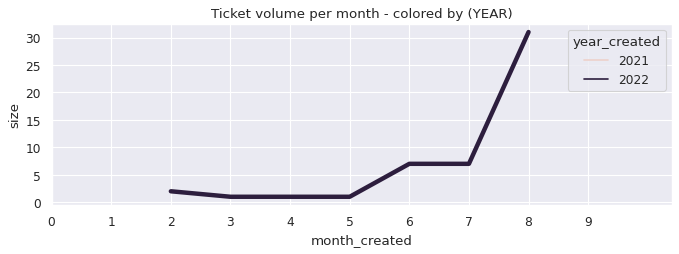

In [25]:
fig = plt.figure(figsize=(10,3),dpi=80)
sns.lineplot(data=ticket_count, x="month_created",y="size",hue="year_created",style="year_created",dashes=False,linewidth=4).set(title='Ticket volume per month - colored by (YEAR)')
plt.xticks(np.arange(0, max(ticket_count["month_created"].to_list()), 1))
plt.show()

In [26]:
grouped_by_date = data.groupby(by=["date_created","year_created"],as_index=False).agg("size")
grouped_by_date

,date_created,year_created,size
0,2021-10-15,2021,1
1,2022-02-09,2022,1
2,2022-02-14,2022,1
3,2022-03-09,2022,1
4,2022-05-26,2022,1
5,2022-06-10,2022,2
6,2022-06-17,2022,1
7,2022-06-22,2022,3
8,2022-06-23,2022,1
9,2022-07-06,2022,1


In [27]:
grouped_by_date["date_created"] = grouped_by_date["date_created"].astype(str)

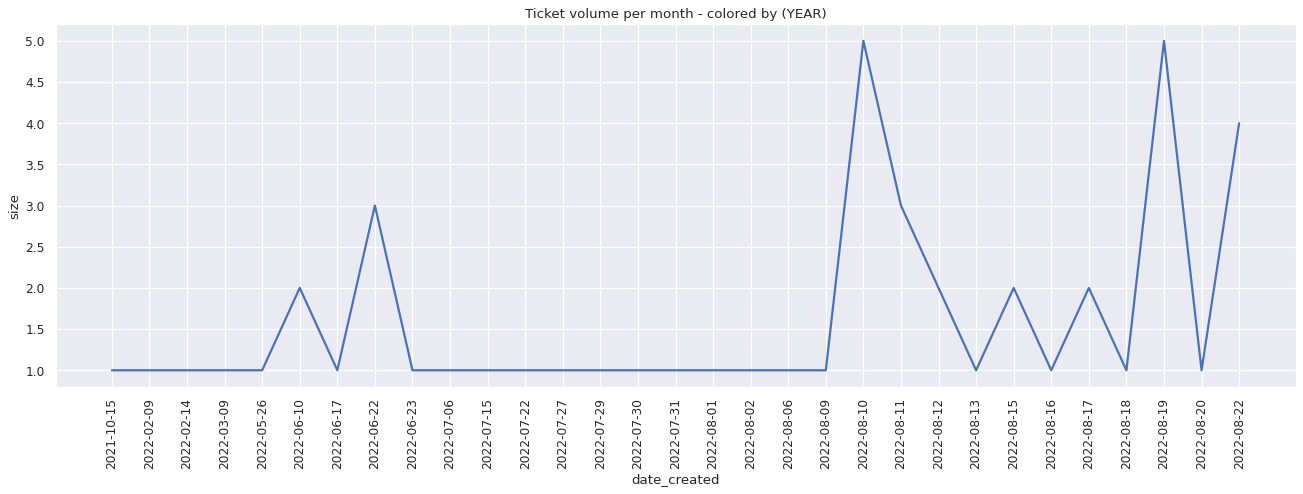

In [28]:
fig = plt.figure(figsize=(20,6),dpi=80)
sns.lineplot(data=grouped_by_date, x="date_created",y="size",dashes=False,linewidth=2).set(title='Ticket volume per month - colored by (YEAR)')
# plt.xticks(np.arange(0, max(ticket_count["month_created"].to_list()), 1))
plt.xticks(rotation=90)
plt.show()